# DTSA 5511 Week 5 Project
### Introduction

The dataset for this project is provided via the Kaggle "GAN Getting Started"/"I'm Something of a Painter Myself" [competition](https://www.kaggle.com/competitions/gan-getting-started). The goal of the project is to use a Generative Adversarial Network (GAN) to adapt real photos to the style of Claude Monet, a famous French painter, using examples of his artwork. 

To reach this goal the dataset (images) will be explored and pre-processed, then a GAN-based model will be trained and used to generate adapted images. The images will then be submitted for a final score in the competition.

All code for this project can be found on my GitHub: https://github.com/nhansendev/DTSA5511_Week5Project

In [1]:
# Import required libraries
import os
import torch
import numpy as np
from torch.utils.data import DataLoader

# Bulky functions have been moved to separate files
from data_handling import CustomDataset
from utils import gen_folder_name
from trainer import Trainer
from constants import RANDOM_SEED, SCRIPT_DIR
from plotting import plot_img_tensor

# For parsing configuration .yaml files 
# https://github.com/nhansendev/AutoConfig
from AutoConfig import args_from_YAML

# A substitute for tqdm, which was behaving strangely
# https://github.com/nhansendev/TimeMarkers
from TimeMarkers import TimeMarker

# Additional optimization
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

# For reproducability
torch.manual_seed(RANDOM_SEED);

### Exploratory Data Analysis
The images were pre-processed into numpy arrays, which can be more rapidly read from disk than loading images one-at-a-time, though it has higher RAM requirements to keep the entire dataset in memory.

Looking at the shape of the data:

In [2]:
# Read image datasets, which have been pre-processed into numpy arrays
dataA = np.load(os.path.join(SCRIPT_DIR, "Data", "monet.npy"))
dataB = np.load(os.path.join(SCRIPT_DIR, "Data", "photo.npy"))

print(dataA.shape)
print(dataB.shape)

(300, 256, 256, 3)
(7038, 256, 256, 3)


The images are in a common format, with shape 256x256 pixels and three color channels (red, green, and blue).

We can see that the number of images in each dataset is heavily imbalanced, with only 300 examples of Monet paintings compared to 7038 examples of photographs. A uniform sampling scheme will be used to ensure that each batch has equal representation of each category.

Visualizing some examples from each cateogry:

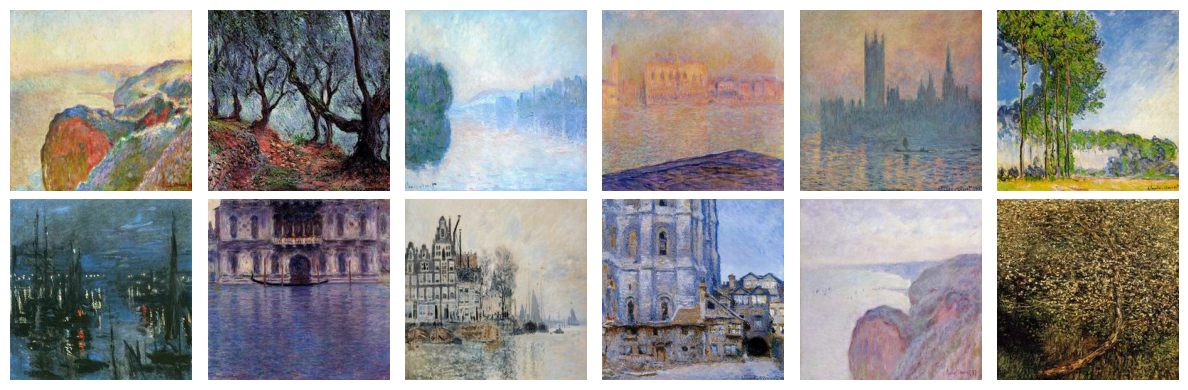

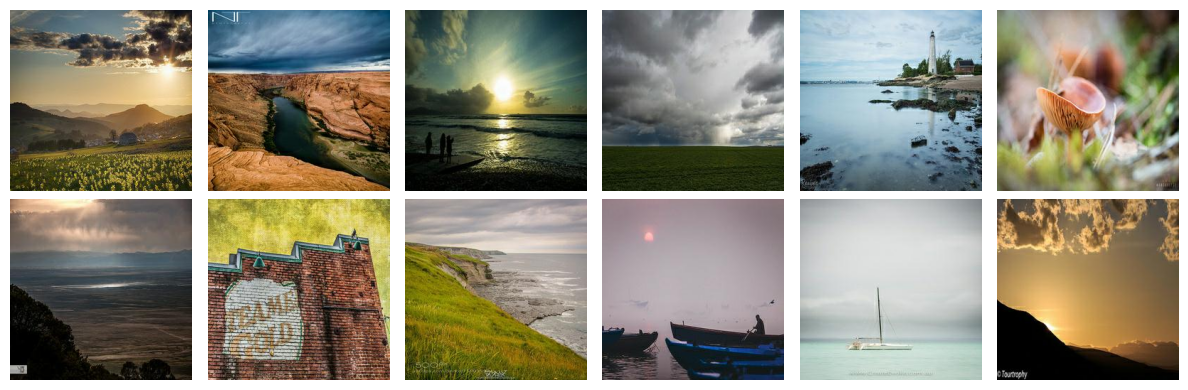

In [3]:
plot_img_tensor(dataA) # monet
plot_img_tensor(dataB) # photo

It's easy to tell the paintings and photos apart (obvious brush-strokes and "fuzzy" features compared to clear, sharp features), and we can see that both depict a wide variety of locations and subjects. However, it can be difficult to interpret what some of the paintings are depicting, such as the top-left example (rocks, or maybe clouds?).

### Data Augmentations
To provide a larger set of images for the model to learn from two data augmentations are applied to each batch:
- Resize and RandomCrop: the images are up-scaled via bicubic interpolation, the randomly cropped back to the original size
- Random Horizontal Flip


### Model Architecture

The GAN-based model chosen for this analysis is a [CycleGAN](https://arxiv.org/pdf/1703.10593), which is constructed of two "generator" networks and two "discriminator" networks. Each generator network takes in images and (once trained) applies the desired style to those images. One will imitate the style of Monet and the other will imitate photorealism. The discriminators will be trained to detect whether the provided images are real Monets/photos, or fake (generated) Monets/photos. 

#### Generator
An example generator architecture is shown here (dots are used to show where the number of channels has been reduced for easier plotting):

Down-sampling is used to rapidly reduce the size of the images while adding more channels, producing a compact encoding of latent features which reduces memory usage while also making the application of filters less computationally intensive. Residual blocks add depth the model, allowing more complex features to be extracted while reducing the likelihood of vanishing or exploding gradients. Finally, up-sampling is used to unpack the latent encodings back to the form-factor of the original images. An implementation of [U-Net](https://arxiv.org/abs/1505.04597) has also been included, which primarily adds channel-concatenating skip-connections between the up-sampling and down-sampling blocks.

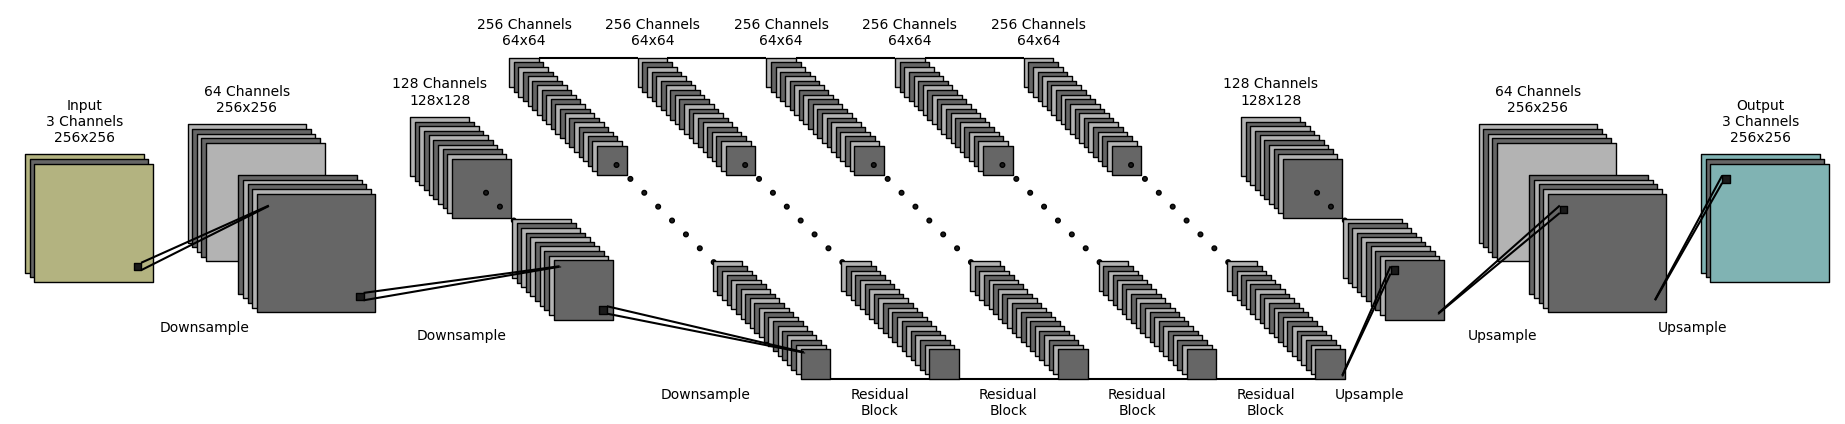

The Up-sampling and Down-sampling blocks make use of ReflectionPad2d, Conv2d or ConvTranspose2d, InstanceNorm2d, and activation (ReLU, or LeakyReLU) layers.

Each Residual Block has the following structure:

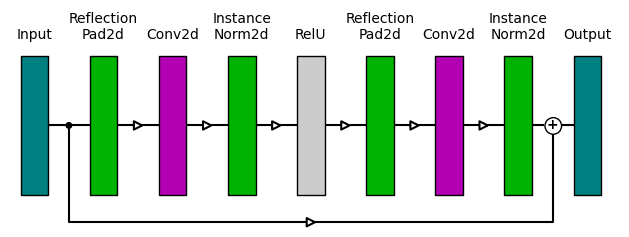

#### Discriminator
An example discrimintor network has the following architecture:

Similarly to the generators, down-sampling is used to rapidly reach a compact latent-encoding of features, but rather than up-sampling again we only need to convert these encodings to a prediction of the image classification. Since an averaging loss function (Mean Squared Error) is used the output can remain in a non-vector format. The average of the output is compared to a prediction of 1.0 for "real" and 0.0 for "fake".

An example of the resulting feature sizes:

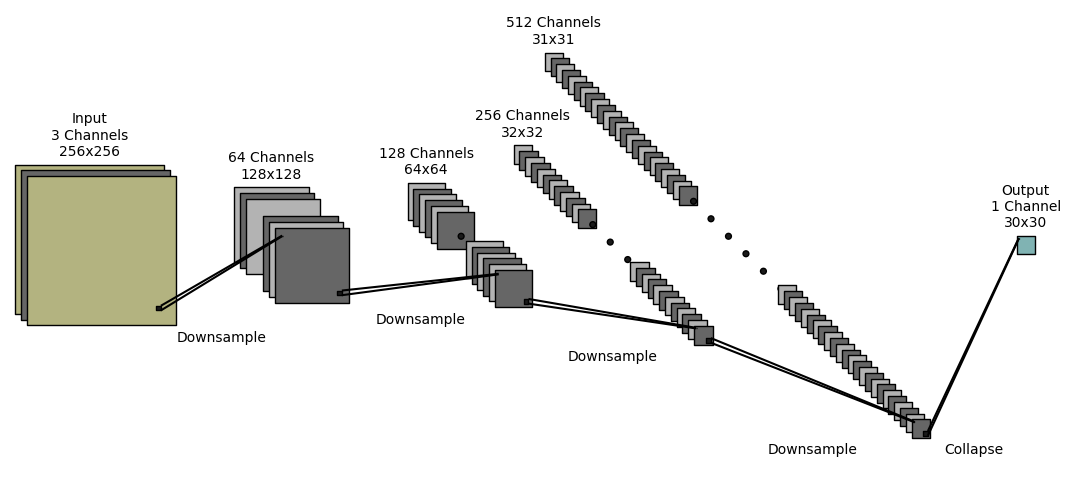

The Generator and Discriminator architectures were adapted from this implementation: https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

Diagrams were generated using: https://github.com/nhansendev/PyDrawNet

#### Loss Calculations
Calculating the loss for a Cycle GAN combines various metrics for the generators and discriminators:

Generators:
- Identity Loss: does applying generator A to real image A return real image A?
    - The generator is encouraged to output images similar to the real inputs
- Cycle Loss: does passing real image A through generator B, then generator A return real image A?
    - The generators are encouraged to learn small changes that don't disrupt each-other
- Discriminator Mistake Loss: do the generated fake images fool the discriminator?
    - The main objective

Discriminators:
- Correct Real Loss: did the discriminator correctly identify a real image?
- Correct Fake Loss: did the discriminator correctly identify a fake image?

A flowchart for the A-side loss is shown below:

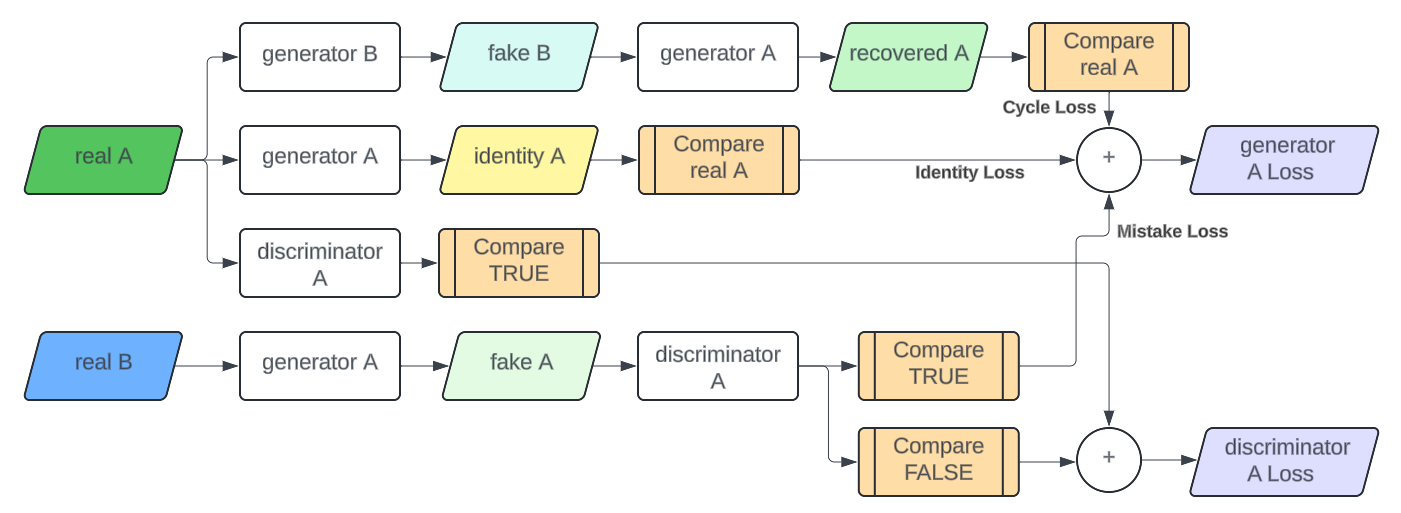

The flowchart was generated via [Lucidchart](https://lucid.app)

#### Image Pools
To help smooth out sudden changes in generated images a pool (buffer) of previously generated fake images is stored for each image category. When training the discriminators half of each batch of fake images is randomly swapped with images from the buffer. The resulting updated batch is then provided to the discriminator for category prediction.

#### Additional Tweaks
Given the difficulty of training GANs there are a variety of additional tweaks that have been collected by the community to improve performance and stability, some of which have been listed in this [github repo](https://github.com/soumith/ganhacks?tab=readme-ov-file). The following have been implemented:
- Normalize the images between -1 and 1
- Tanh as the last layer of the generator output
- Mini-batches provided to the discriminator should have all real or all fake images, not a mix
- Use LeakyReLU instead of ReLU
- Use Convolution and stride when up and down-sampling
- Use soft and noisy labels
    - Real is a random number near 1, fake is a random number near 0
    - Occasionally flip labels when training the discriminator
- Experience Replay (Image Pools)
- Adam optimizer for generator, SGD for discriminator
- Add random noise to the images for the discriminator
- Use dropout in the generator

### Model Setup and Training

In [ ]:
# Parse config file
args = args_from_YAML(os.path.join(SCRIPT_DIR, "config.yaml"))

# Create a working directory to store results
working_dir = gen_folder_name(os.path.join(SCRIPT_DIR, "Results"))
print(f"Current Working Directory:", working_dir)

# Save a copy of the config file for future reference
args.save_to_yaml(os.path.join(working_dir, "config.yaml"))

# Set up custom data-loader to apply data augmentations and generate batches
DS = CustomDataset(dataA, dataB)
DL = DataLoader(DS, args.batch_size)

# The trainer will hold the models and handle loss calculations, history tracking, schedule updates, etc.
tr = Trainer(working_dir, DS.dataA[:6].cuda(), DS.dataB[:6].cuda(), args)

# Perform training
total_iters = 0
for i in TimeMarker(range(args.epochs), oneline=False, segments=[1, 6, 5, 4, 2]):
    for _ in TimeMarker(range(args.epoch_len), oneline=True, segments=[1, 6, 5, 4, 2]):
        A, B = next(iter(DL)) # make batch
        tr.step(A, B) # training step
        total_iters += 1
        if total_iters % args.out_ival == 0:
            tr.checkpoint() # save model and update visualizations
    tr.save_models()

Current Working Directory: d:\Atom\MSDS\DTSA5511\CycleGAN\Results\0053
| 2024-10-12 06:47:24 PM | |██████████████████████████████████████████████████| | 1200/1200 (100.0%) | 00:00.308 per step | 03:20 / 00:00 E/R |
| 2024-10-12 06:47:24 PM | |███      .         .         .         .         .| |  1/15 (  6.7%) | 03:20.182 per step | 03:20 / 46:42 E/R |
| 2024-10-12 06:50:42 PM | |██████████████████████████████████████████████████| | 1200/1200 (100.0%) | 00:00.310 per step | 03:18 / 00:00 E/R |
| 2024-10-12 06:50:43 PM | |██████   .         .         .         .         .| |  2/15 ( 13.3%) | 03:20.033 per step | 06:38 / 43:12 E/R |
| 2024-10-12 06:54:03 PM | |██████████████████████████████████████████████████| | 1200/1200 (100.0%) | 00:00.364 per step | 03:19 / 00:00 E/R |
| 2024-10-12 06:54:03 PM | |██████████         .         .         .         .| |  3/15 ( 20.0%) | 03:20.044 per step | 09:59 / 39:56 E/R |
| 2024-10-12 06:57:24 PM | |█████████████████████████████████████████████████

### Results

### Conclusion

### References

1. I’m Something of a Painter Myself. (n.d.). Kaggle. https://www.kaggle.com/competitions/gan-getting-started/overview

2. junyanz/pytorch-CycleGAN-and-pix2pix: Image-to-Image Translation in PyTorch. (n.d.). https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

3. Amyjang. (2020, August 29). Monet CycleGAN Tutorial. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial#Introduction-and-Setup

4. Soumith. (n.d.). GitHub - soumith/ganhacks: starter from “How to Train a GAN?” at NIPS2016. GitHub. https://github.com/soumith/ganhacks?tab=readme-ov-file

5. Brownlee, J. (2021, January 20). How to identify and diagnose GAN failure modes. MachineLearningMastery.com. https://machinelearningmastery.com/practical-guide-to-gan-failure-modes/

6. Ronneberger, O., Fischer, P., & Brox, T. (2015, May 18). U-NET: Convolutional Networks for Biomedical Image Segmentation. arXiv.org. https://arxiv.org/abs/1505.04597